In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib
# matplotlib.use('agg')
# matplotlib.use('TkAgg')
# matplotlib.use('qtagg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import *
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from math import *
#import pandas as pd

from scipy import interpolate
from scipy.optimize import curve_fit 

from astropy.io import fits
from astropy.table import Table
from astropy.table import vstack
from astropy.coordinates import SkyCoord, ICRS, Galactic
# import astropy.units as u
import astropy.units as units
import astropy.coordinates as coord
#from matplotlib.colors import LogNorm

# from mpl_toolkits.axes_grid1 import make_axes_locatable
# #import matplotlib.ticker as mtick


import os
#%matplotlib widget
import seaborn as sns
import os, sys


# from astropy.io import ascii
# from astropy.coordinates import galactocentric_frame_defaults

import sklearn
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier

from scipy import interpolate

import random
from scipy import integrate


gcolor = ['c','blue','g','r','orange', 'green','cyan']

In [2]:
import ppxf as ppxf_package
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.sps_util as lib
import sys,glob
from pathlib import Path

from ppxf.ppxf import ppxf, robust_sigma

from vorbin.voronoi_2d_binning import voronoi_2d_binning
from plotbin.display_bins import display_bins

from tqdm import tqdm  

In [3]:
c = 299792.458  # spped of light [km/s]

galaxy_name = 'VCC_1588'
spectrum_filename = 'VCC1588_stack.fits'
spectrum_z = 0.0042

In [4]:
lam_range_temp = [4820, 5220]
redshift = spectrum_z           # redshift from
objfile = Path('./../Ori_Data/'+spectrum_filename)

In [5]:
# templates

sps_name = 'emiles'
ppxf_dir = Path(lib.__file__).parent
basename = f"spectra_{sps_name}_9.0.npz"
filename = ppxf_dir / 'sps_models' / basename

In [6]:
# vel_s = c * spectrum_z
vel_s = 0
vel_dis_s = 40 # Set the dis v = 40 km/s

In [7]:
## Code from example

class read_data_cube:
    def __init__(self, filename, lam_range, redshift):
        """Read data cube, de-redshift, log rebin and compute coordinates of each spaxel."""

        self.read_fits_file(filename)

        # Only use the specified rest-frame wavelength range
        wave = self.wave/(1 + redshift)      # de-redshift the spectrum
        w = (wave > lam_range[0]) & (wave < lam_range[1])
        wave = wave[w]
        cube = self.cube[w, ...]
        cubevar = self.cubevar[w, ...]

        signal = np.nanmedian(cube, 0)
        noise = np.sqrt(np.nanmedian(cubevar, 0))

        # Create coordinates centred on the brightest spaxel
        jm = np.argmax(signal)
        row, col = map(np.ravel, np.indices(cube.shape[-2:]))
        x = (col - col[jm])*self.pixsize_x
        y = (row - row[jm])*self.pixsize_y

        # Transform cube into 2-dim array of spectra
        npix = cube.shape[0]
        spectra = cube.reshape(npix, -1)        # create array of spectra [npix, nx*ny]
        variance = cubevar.reshape(npix, -1)    # create array of variance [npix, nx*ny]

        c = 299792.458  # speed of light in km/s
        velscale = np.min(c*np.diff(np.log(wave)))  # Preserve smallest velocity step
        lam_range_temp = [np.min(wave), np.max(wave)]
        spectra, ln_lam_gal, velscale = util.log_rebin(lam_range_temp, spectra, velscale=velscale)

        # Coordinates and spectra only for spaxels with enough signal
        self.spectra = spectra
        self.variance = variance
        self.x = x
        self.y = y
        self.signal = signal.ravel()
        self.noise = noise.ravel()

        self.col = col + 1   # start counting from 1
        self.row = row + 1
        self.velscale = velscale
        self.ln_lam_gal = ln_lam_gal
        self.fwhm_gal = self.fwhm_gal/(1 + redshift)

        self.velfield = np.ndarray(shape=self.cube.shape[1:3])
        self.sigfield = np.ndarray(shape=self.cube.shape[1:3])

        # self.CD1_1 = self.CD1_1
        # self.CD1_2 = self.CD1_2
        # self.CD2_1 = self.CD2_1
        # self.CD2_2 = self.CD2_2
        # self.CRVAL1 = self.CRVAL1
        # self.CRVAL2 = self.CRVAL2

###############################################################################

    def read_fits_file(self, filename):
        """
        Read MUSE cube, noise, wavelength, spectral FWHM and pixel size.

        It must return the cube and cuberr as (npix, nx, ny) and wave as (npix,)

        IMPORTANT: This is not a general function! Its details depend on the
        way the data were stored in the FITS file and the available keywords in
        the FITS header. One may have to adapt the function to properly read
        the FITS file under analysis.                
        """

        Cut_LHS = 2
        Cut_RHS = 2

        hdu = fits.open(filename)
        head = hdu[0].header
        cube = hdu[0].data[Cut_LHS:-Cut_RHS,:,:] * (10 ** 18)
        # cube = hdu[0].data[Cut_LHS:-Cut_RHS,:,:]
        # cube = hdu[0].data * (10 ** 18)
        cubevar = np.empty_like(cube)  # This file contains no errors

        # Only use the specified rest-frame wavelength range
        wave = head['CRVAL3'] + head['CD3_3']*np.arange(cube.shape[0]) + head['CD3_3']*Cut_LHS

        self.cube = cube
        self.cubevar = cubevar
        self.wave = wave
        
        # self.fwhm_gal = 2.62  # Median FWHM = 2.62Å. Range: 2.51--2.88 (ESO instrument manual). 
        self.fwhm_gal = 1
        # self.pixsize = abs(head["CDELT1"])*3600    # 0.2"
        self.pixsize_x = abs(np.sqrt((head['CD1_1'])**2+(head['CD2_1'])**2))*3600
        self.pixsize_y = abs(np.sqrt((head['CD1_2'])**2+(head['CD2_2'])**2))*3600

        self.CD1_1 = head['CD1_1']
        self.CD1_2 = head['CD1_2']
        self.CD2_1 = head['CD2_1']
        self.CD2_2 = head['CD2_2']
        self.CRVAL1 = head['CRVAL1']
        self.CRVAL2 = head['CRVAL2']

In [8]:
Galaxy_info = read_data_cube(objfile, lam_range_temp, redshift)

In [9]:
Galaxy_info.wave

array([4819.82, 4820.01, 4820.2 , ..., 5261.19, 5261.38, 5261.57])

In [10]:
FWHM_gal = None   # set this to None to skip templates broadening
sps = lib.sps_lib(filename, Galaxy_info.velscale, FWHM_gal, norm_range=[4827.875, 5206.375])
# sps = lib.sps_lib(filename, Galaxy_info.velscale, FWHM_gal)

In [11]:
sps.templates.shape

(93618, 25, 6)

In [12]:
npix, *reg_dim = sps.templates.shape
sps.templates = sps.templates.reshape(npix, -1)
sps.templates /= np.median(sps.templates) # Normalizes stellar templates by a scalar
regul_err = 0.01 # Desired regularization error

lam_range_temp = np.exp(sps.ln_lam_temp[[0, -1]])
mask0 = util.determine_mask(Galaxy_info.ln_lam_gal, lam_range_temp, width=1000)
# nbins = np.unique(bin_num).size
# velbin, sigbin, lg_age_bin, metalbin, nspax = np.zeros((5, nbins))
# optimal_templates = np.empty((npix, nbins))
lam_gal = np.exp(Galaxy_info.ln_lam_gal)

In [13]:
lam_gal

array([4820.08835353, 4820.26307371, 4820.43780022, ..., 5219.45066858,
       5219.63986498, 5219.82906824])

In [14]:
def Cube_sol(Galaxy_cube, redshift):
    
    plt.figure(figsize=(16, 3))
    ##-----------------------------------------------
    galaxies = np.ndarray(shape= (Galaxy_cube.spectra[:,0].shape[0],Galaxy_cube.cube.shape[1],Galaxy_cube.cube.shape[2]))
    # print(Galaxy_cube.cube.shape)
    for i in range(Galaxy_cube.cube.shape[1]):
        for j in range(Galaxy_cube.cube.shape[2]):
            # galaxy,logLam1,velscale = util.log_rebin(np.array([np.min(Galaxy_cube.wave), np.max(Galaxy_cube.wave)]),Galaxy_cube.cube[:,i,j])
            # galaxy = galaxy/np.median(galaxy)

            galaxies[:,i,j] = Galaxy_cube.spectra[:,i*max(Galaxy_cube.col)+j]
    # plt.plot(galaxies[:,10,20])

    # logLam10 = logLam1[:]
    # logLam1 = logLam10[200:-200]

    velscale_ratio = 2
    velscale = Galaxy_cube.velscale

    velfield = np.ndarray(shape=galaxies.shape[1:3])+np.nan
    sigfield = np.ndarray(shape=galaxies.shape[1:3])+np.nan
    tempnum = np.ndarray(shape=galaxies.shape[1:3])
    Bestfitfield = np.ndarray(shape=galaxies.shape)

    optimal_templates = np.ndarray(shape=(npix,galaxies.shape[1],galaxies.shape[2]))
    # pp_field = [[None]*Galaxy_cube.cube.shape[2]]*Galaxy_cube.cube.shape[1]
    # print(pp_field[0][1])
    apoly=[]
    weights_box = []

    for i in tqdm(range(galaxies.shape[1])):
        for j in range(galaxies.shape[2]):
            if(i == 11 and j == 43):                 # -------------------------- Here is the test sentence -------------------------- Here is the test sentence
                plot_TF = True if (i == 11 and j == 43) else False
                tmpgalaxy = galaxies[:,i,j]
                noise = np.full_like(tmpgalaxy,0.1)
                noise = np.ones_like(tmpgalaxy)
                if np.count_nonzero(tmpgalaxy) > 50:
                    pp = ppxf(sps.templates, tmpgalaxy, noise, velscale, [vel_s, vel_dis_s],
                            degree=3,
                            plot=plot_TF, mask=mask0, lam=lam_gal, lam_temp=sps.lam_temp, quiet=not plot_TF)
                    # pp_field[i][j]=pp
                    Bestfitfield[:,i,j]=pp.bestfit

                    pp.optimal_template = sps.templates.reshape(sps.templates.shape[0], -1) @ pp.weights
                    optimal_templates[:,i,j] = pp.optimal_template
                    velfield[i,j] = pp.sol[0]
                    sigfield[i,j] = pp.sol[1]
                    weights = pp.weights
                    weights_box += [weights]
                    indwt = np.where(weights == np.max(weights))[0]
                    tempnum[i,j] = indwt[0]
                    apoly += [pp.apoly]

                    print(pp.mpoly)

    # return velfield, sigfield, pp_field
    return velfield, sigfield, Bestfitfield, optimal_templates, apoly, weights_box

  0%|          | 0/23 [00:00<?, ?it/s]

 Best Fit:       Vel     sigma
 comp.  0:        35        12
chi2/DOF: 38.43; DOF: 1645; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 21; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 6/150


100%|██████████| 23/23 [00:00<00:00, 27.49it/s]

None


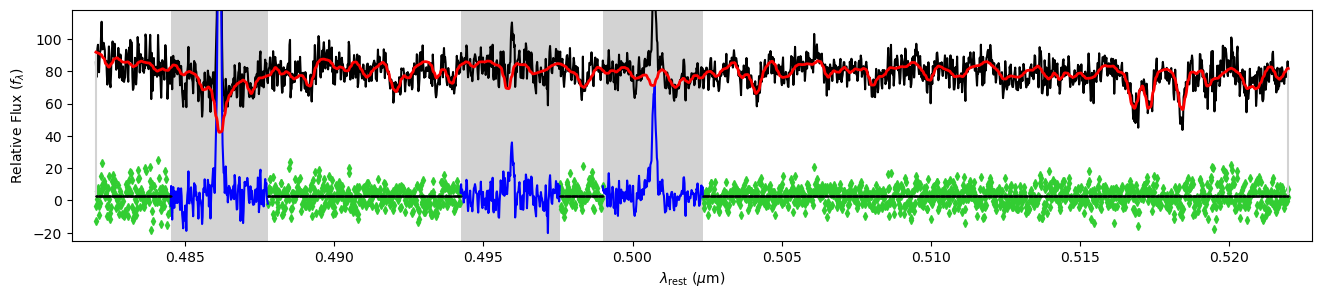

In [15]:
velfield, sigfield, Bestfitfield, optimal_templates, apoly, weights_box = Cube_sol(Galaxy_info, redshift)

In [16]:
len(apoly[0])

2199

In [17]:
len(sps.lam_temp)

93618

In [18]:
apoly_se = np.polyfit(lam_gal, apoly[0], 3)

In [19]:
lam_gal.shape[0]

2199

In [20]:
# apoly_se = np.polyfit(lam_gal, apoly[0], 3)

# def apoly_list(lam, apoly_se):
#     ploy_ad = np.ndarray(shape=lam.shape)
#     for i in range(ploy_ad.shape[0]):
#         ploy_ad[i] =  apoly_se[0] * lam[i]**3 + apoly_se[1] * lam[i]**2 + apoly_se[2] * lam[i] + apoly_se[0]

In [21]:
apoly_se

array([-1.08362031e-06,  1.63776283e-02, -8.24771685e+01,  1.38376993e+05])

In [22]:
np.poly1d(apoly_se)(lam_gal)

array([-15.34340439, -15.36470012, -15.38595342, ..., -20.13993221,
       -20.15411267, -20.16833593])

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_16616\3650522537.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


c:\ProgramData\Anaconda3\envs\Ast_Base\lib\site-packages\IPython\core\events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
c:\ProgramData\Anaconda3\envs\Ast_Base\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


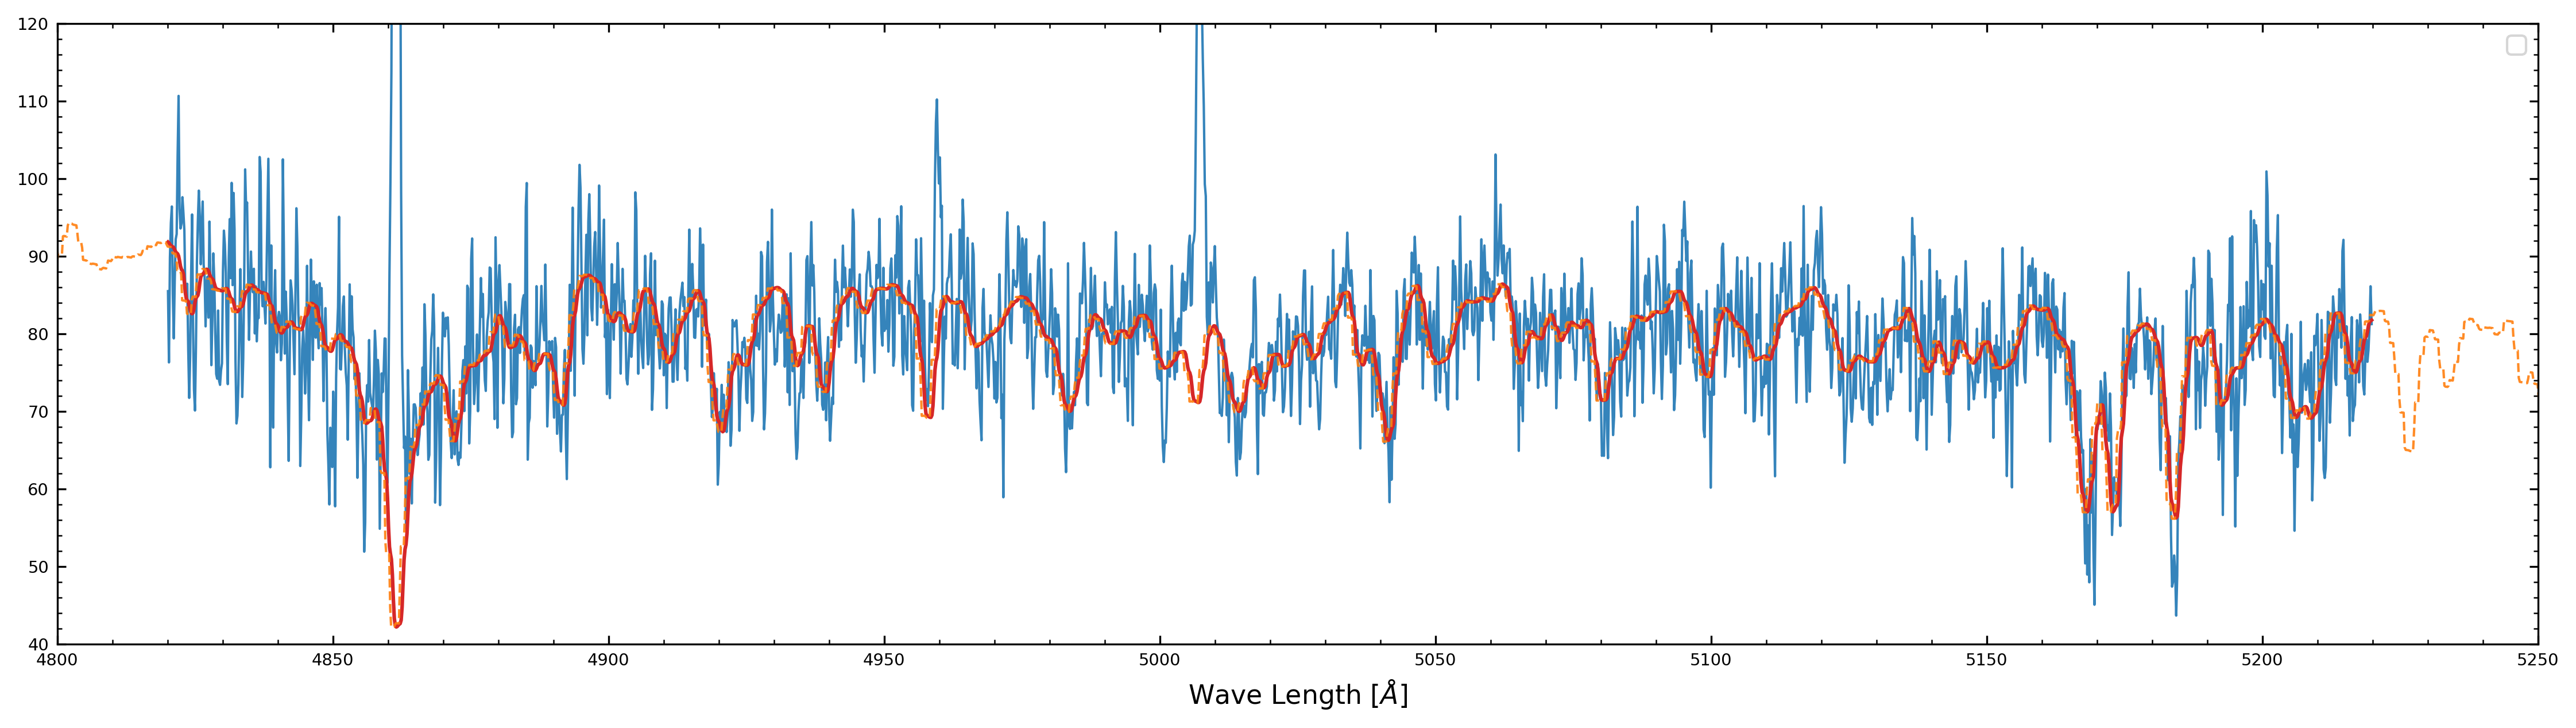

In [23]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,4), dpi=300, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.95, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

ax1.plot(lam_gal,Galaxy_info.spectra[:,1000], c='tab:blue', lw=1, alpha=.9)
ax1.plot(lam_gal,Bestfitfield[:,11,43], c='tab:red')
ax1.plot(sps.lam_temp,optimal_templates[:,11,43] + np.poly1d(apoly_se)(sps.lam_temp),'--', c='tab:orange', lw=1, alpha=.9)
ax1.plot(sps.lam_temp,np.poly1d(apoly_se)(sps.lam_temp),'--', c='tab:green', lw=1, alpha=.9)


ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


ax1.set_xlabel(r'', size=11)
ax1.set_ylabel(r'', size=11)

ax1.set_ylim(40,120)
ax1.set_xlim(4800,5250)
ax1.set_xlabel(r'Wave Length $[\AA]$', size=11)
ax1.legend()

# plt.savefig('./', format='pdf', bbox_inches='tight')

In [24]:
# import numpy as np
# from astropy.io import fits
# from scipy import interpolate
# import matplotlib.pyplot as plt

# class LineIndexCalculator:
#     def __init__(self, wave, flux, error=None):
#         """
#         初始化吸收线指数计算器
        
#         Parameters:
#         -----------
#         wave : array-like
#             波长数组
#         flux : array-like
#             流量数组
#         error : array-like, optional
#             误差数组
#         """
#         self.wave = wave
#         self.flux = flux
#         self.error = error if error is not None else np.ones_like(flux)
        
#     def define_line_windows(self, line_name):
#         """
#         定义吸收线和连续谱窗口
        
#         Returns:
#         --------
#         dict : 包含蓝端、中心和红端窗口的字典
#         """
#         windows = {
#             'Hbeta': {
#                 'blue': (4827.875, 4847.875),
#                 'line': (4847.875, 4876.625),
#                 'red': (4876.625, 4891.625)
#             },
#             'Mgb': {
#                 'blue': (5142.625, 5161.375),
#                 'line': (5160.125, 5192.625),
#                 'red': (5191.375, 5206.375)
#             },
#             'Fe5015': {
#                 'blue': (4946.500, 4977.750),
#                 'line': (4977.750, 5054.000),
#                 'red': (5054.000, 5065.250)
#             }
#         }
#         return windows.get(line_name)

#     def calculate_pseudo_continuum(self, wave_range, flux_range):
#         """
#         计算伪连续谱
#         """
#         return np.median(flux_range)

#     def calculate_index(self, line_name, return_error=False):
#         """
#         计算吸收线指数
        
#         Parameters:
#         -----------
#         line_name : str
#             吸收线名称 ('Hbeta', 'Mgb', 或 'Fe5015')
#         return_error : bool
#             是否返回误差
            
#         Returns:
#         --------
#         float : 吸收线指数值
#         float : 误差值（如果return_error=True）
#         """
#         # 获取窗口定义
#         windows = self.define_line_windows(line_name)
#         if windows is None:
#             raise ValueError(f"未知的吸收线: {line_name}")

#         # 提取各个区域的数据
#         def get_region(region):
#             mask = (self.wave >= windows[region][0]) & (self.wave <= windows[region][1])
#             return self.wave[mask], self.flux[mask], self.error[mask]

#         blue_wave, blue_flux, blue_err = get_region('blue')
#         line_wave, line_flux, line_err = get_region('line')
#         red_wave, red_flux, red_err = get_region('red')

#         # 计算蓝端和红端连续谱水平
#         blue_cont = self.calculate_pseudo_continuum(blue_wave, blue_flux)
#         red_cont = self.calculate_pseudo_continuum(red_wave, red_flux)

#         # 计算连续谱
#         wave_cont = np.array([np.mean(blue_wave), np.mean(red_wave)])
#         flux_cont = np.array([blue_cont, red_cont])
        
#         # 线性插值得到中心区域的连续谱
#         f_interp = interpolate.interp1d(wave_cont, flux_cont)
#         cont_at_line = f_interp(line_wave)

#         # 计算指数
#         delta_lambda = np.mean(np.diff(line_wave))
#         index = np.sum((1.0 - line_flux/cont_at_line) * delta_lambda)

#         if return_error:
#             # 计算误差
#             error = self._calculate_error(line_wave, line_flux, line_err, 
#                                         cont_at_line, delta_lambda)
#             return index, error
        
#         return index

#     def _calculate_error(self, wave, flux, error, cont, delta_lambda):
#         """
#         计算指数误差
#         """
#         variance = np.sum((error/cont * delta_lambda)**2)
#         return np.sqrt(variance)

#     def plot_line_fit(self, line_name):
#         """
#         绘制吸收线拟合结果
#         """
#         windows = self.define_line_windows(line_name)
        
#         plt.figure(figsize=(10, 6))
        
#         # 绘制原始光谱
#         plt.plot(self.wave, self.flux, 'k-', label='Observed Spectrum')
        
#         # 标记各个区域
#         colors = {'blue': 'b', 'line': 'g', 'red': 'r'}
#         for region, (start, end) in windows.items():
#             mask = (self.wave >= start) & (self.wave <= end)
#             plt.axvspan(start, end, alpha=0.2, color=colors[region])
            
#         plt.xlabel('Wavelength (Å)')
#         plt.ylabel('Flux')
#         plt.title(f'{line_name} Index Measurement')
#         plt.legend()
#         plt.grid(True, alpha=0.3)
#         plt.show()

# # 使用示例
# def main():
#     # 假设我们已经有了波长和流量数据
#     # 这里创建一个示例数据
#     # wave = np.linspace(4800, 5300, 1000)
#     # # 创建一个模拟的光谱，包含Hbeta吸收线
#     # continuum = np.ones_like(wave)
#     # # 添加高斯吸收线
#     # absorption = 0.2 * np.exp(-(wave - 4861)**2 / (2 * 3**2))
#     # flux = continuum - absorption

#     wave = sps.lam_temp
#     flux = optimal_templates[:,11,43] + np.poly1d(apoly_se)(sps.lam_temp)
    
#     # 初始化计算器
#     calculator = LineIndexCalculator(wave, flux)
    
#     # 计算Hbeta指数
#     hbeta_index = calculator.calculate_index('Hbeta')
#     print(f"Hbeta index: {hbeta_index:.3f} Å")
    
#     # 绘制结果
#     calculator.plot_line_fit('Hbeta')

#     # 计算其他指数
#     mgb_index = calculator.calculate_index('Mgb')
#     fe5015_index = calculator.calculate_index('Fe5015')
    
#     print(f"Mg b index: {mgb_index:.3f} Å")
#     print(f"Fe5015 index: {fe5015_index:.3f} Å")

# if __name__ == "__main__":
#     main()

In [25]:
import numpy as np
from astropy.io import fits
from scipy import interpolate
import matplotlib.pyplot as plt

class LineIndexCalculator:
    def __init__(self, wave, flux, velocity_correction=0, error=None):
        """
        初始化吸收线指数计算器
        
        Parameters:
        -----------
        wave : array-like
            波长数组
        flux : array-like
            流量数组
        velocity_correction : float, optional
            速度修正值，单位为km/s，默认为0
        error : array-like, optional
            误差数组
        """
        self.c = 299792.458  # 光速，单位为km/s
        self.velocity = velocity_correction
        # 进行速度修正
        self.wave = self._apply_velocity_correction(wave)
        self.flux = flux
        self.error = error if error is not None else np.ones_like(flux)
    
    def _apply_velocity_correction(self, wave):
        """
        应用速度修正到波长
        
        Parameters:
        -----------
        wave : array-like
            原始波长数组
            
        Returns:
        --------
        array-like : 修正后的波长数组
        """
        return wave / (1 + self.velocity/self.c)
        
    def define_line_windows(self, line_name):
        """
        定义吸收线和连续谱窗口
        
        Returns:
        --------
        dict : 包含蓝端、中心和红端窗口的字典
        """
        windows = {
            'Hbeta': {
                'blue': (4827.875, 4847.875),
                'line': (4847.875, 4876.625),
                'red': (4876.625, 4891.625)
            },
            'Mgb': {
                'blue': (5142.625, 5161.375),
                'line': (5160.125, 5192.625),
                'red': (5191.375, 5206.375)
            },
            'Fe5015': {
                'blue': (4946.500, 4977.750),
                'line': (4977.750, 5054.000),
                'red': (5054.000, 5065.250)
            }
        }
        return windows.get(line_name)

    def calculate_pseudo_continuum(self, wave_range, flux_range):
        """
        计算伪连续谱
        """
        return np.median(flux_range)

    def calculate_index(self, line_name, return_error=False):
        """
        计算吸收线指数
        
        Parameters:
        -----------
        line_name : str
            吸收线名称 ('Hbeta', 'Mgb', 或 'Fe5015')
        return_error : bool
            是否返回误差
            
        Returns:
        --------
        float : 吸收线指数值
        float : 误差值（如果return_error=True）
        """
        # 获取窗口定义
        windows = self.define_line_windows(line_name)
        if windows is None:
            raise ValueError(f"未知的吸收线: {line_name}")

        # 提取各个区域的数据
        def get_region(region):
            mask = (self.wave >= windows[region][0]) & (self.wave <= windows[region][1])
            return self.wave[mask], self.flux[mask], self.error[mask]

        blue_wave, blue_flux, blue_err = get_region('blue')
        line_wave, line_flux, line_err = get_region('line')
        red_wave, red_flux, red_err = get_region('red')

        # 检查是否有足够的点
        if len(blue_flux) < 3 or len(line_flux) < 3 or len(red_flux) < 3:
            return np.nan if not return_error else (np.nan, np.nan)

        # 计算蓝端和红端连续谱水平
        blue_cont = self.calculate_pseudo_continuum(blue_wave, blue_flux)
        red_cont = self.calculate_pseudo_continuum(red_wave, red_flux)

        # 计算连续谱
        wave_cont = np.array([np.mean(blue_wave), np.mean(red_wave)])
        flux_cont = np.array([blue_cont, red_cont])
        
        # 线性插值得到中心区域的连续谱
        f_interp = interpolate.interp1d(wave_cont, flux_cont)
        cont_at_line = f_interp(line_wave)

        # 计算指数
        delta_lambda = np.mean(np.diff(line_wave))
        index = np.sum((1.0 - line_flux/cont_at_line) * delta_lambda)

        if return_error:
            error = self._calculate_error(line_wave, line_flux, line_err, 
                                        cont_at_line, delta_lambda)
            return index, error
        
        return index

    def _calculate_error(self, wave, flux, error, cont, delta_lambda):
        """
        计算指数误差
        """
        variance = np.sum((error/cont * delta_lambda)**2)
        return np.sqrt(variance)

    def plot_line_fit(self, line_name):
        """
        绘制吸收线拟合结果
        """
        windows = self.define_line_windows(line_name)
        
        plt.figure(figsize=(10, 6))
        
        # 绘制原始光谱
        plt.plot(self.wave, self.flux, 'k-', label='Observed Spectrum')
        
        # 标记各个区域
        colors = {'blue': 'b', 'line': 'g', 'red': 'r'}
        for region, (start, end) in windows.items():
            mask = (self.wave >= start) & (self.wave <= end)
            plt.axvspan(start, end, alpha=0.2, color=colors[region])
            
        plt.xlabel('Wavelength (Å)')
        plt.ylabel('Flux')
        plt.title(f'{line_name} Index Measurement (v={self.velocity:.1f} km/s)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

# # 使用示例
# def main():
#     # 创建示例数据
#     # wave = np.linspace(4800, 5300, 1000)
#     # continuum = np.ones_like(wave)
#     # absorption = 0.2 * np.exp(-(wave - 4861)**2 / (2 * 3**2))
#     # flux = continuum - absorption

#     wave = sps.lam_temp
#     flux = optimal_templates[:,11,43] + np.poly1d(apoly_se)(sps.lam_temp)
    
#     # 使用不同的速度修正值进行测试
#     velocities = [34]  # km/s
    
#     for vel in velocities:
#         # 初始化计算器
#         calculator = LineIndexCalculator(wave, flux, velocity_correction=vel)
        
#         # 计算Hbeta指数
#         hbeta_index = calculator.calculate_index('Hbeta')
#         print(f"\nVelocity correction: {vel} km/s")
#         print(f"Hbeta index: {hbeta_index:.3f} Å")
        
#         # 绘制结果
#         calculator.plot_line_fit('Hbeta')

# if __name__ == "__main__":
#     main()

In [26]:
wave = sps.lam_temp
flux = optimal_templates[:,11,43] + np.poly1d(apoly_se)(sps.lam_temp)
calculator = LineIndexCalculator(wave, flux, velocity_correction=34)
        
        # 计算Hbeta指数
hbeta_index = calculator.calculate_index('Hbeta')
Mgb_index = calculator.calculate_index('Mgb')
Fe5015_index = calculator.calculate_index('Fe5015')

In [27]:
hbeta_index, Mgb_index, Fe5015_index

(4.007936297550909, 2.1596029601330504, 5.650040441337278)

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_16616\921316208.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


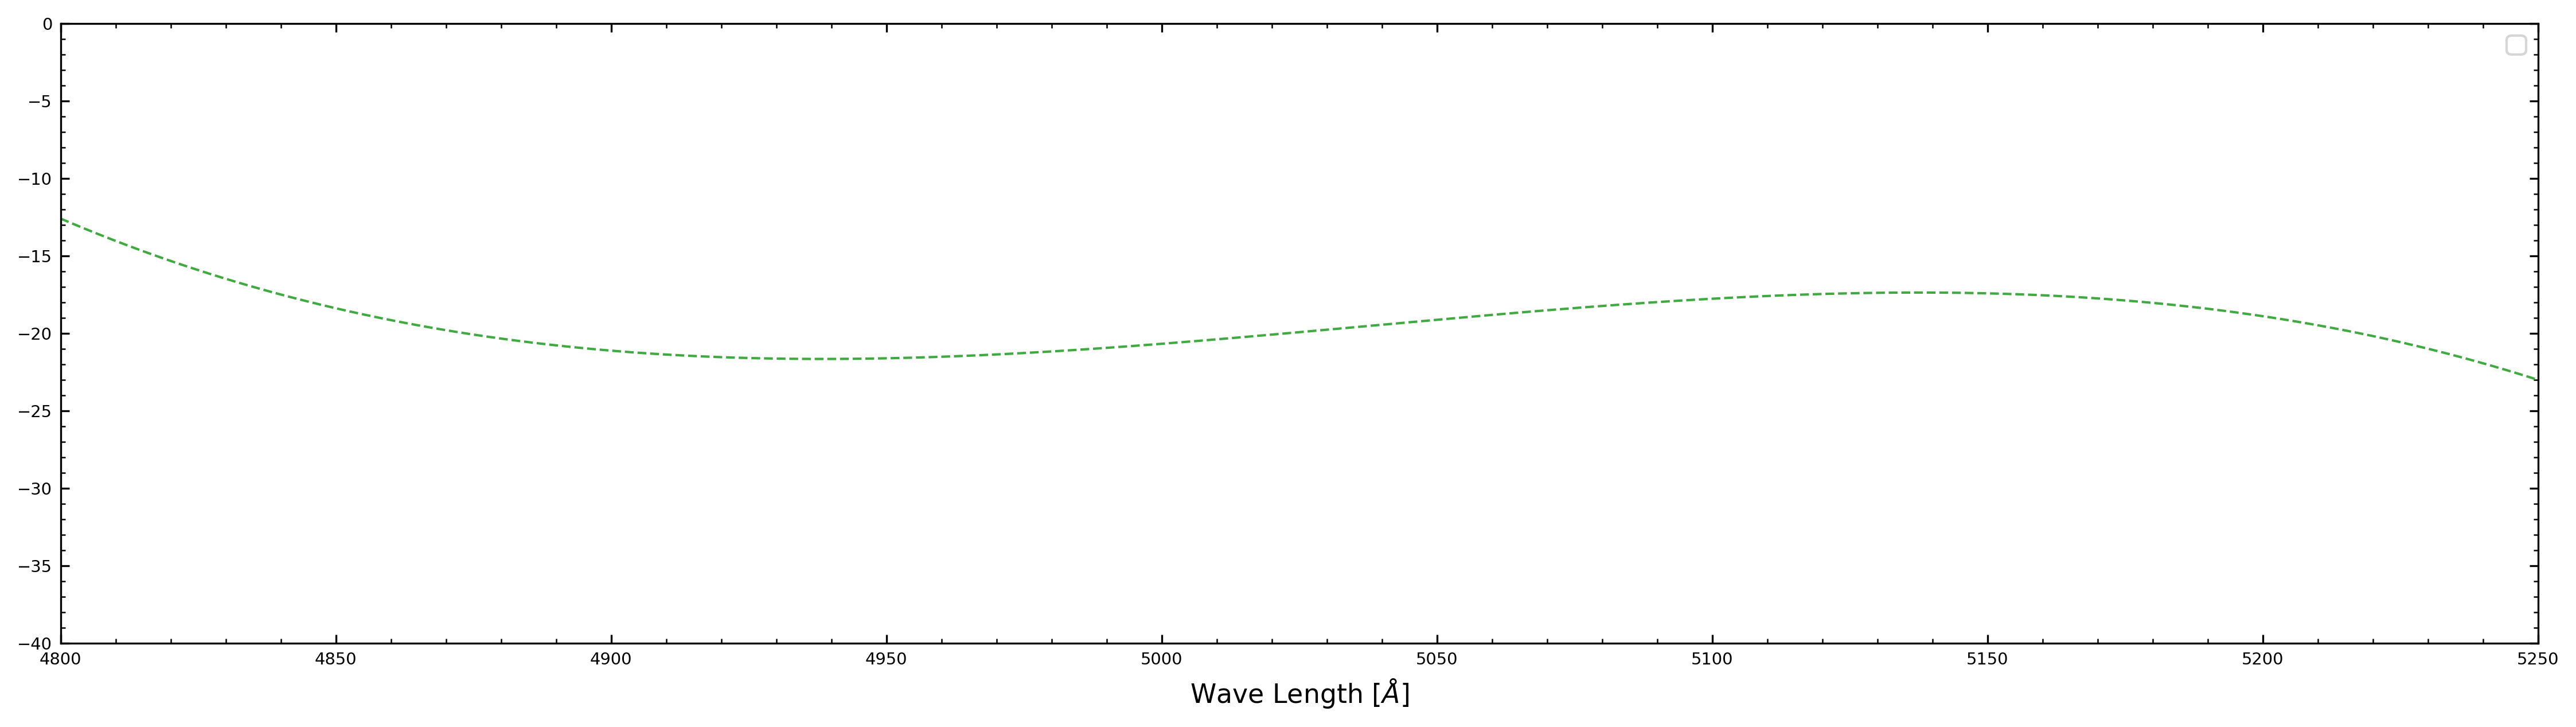

In [28]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,4), dpi=300, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.95, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

ax1.plot(lam_gal,Galaxy_info.spectra[:,1000], c='tab:blue', lw=1, alpha=.9)
ax1.plot(lam_gal,Bestfitfield[:,11,43], c='tab:red')
ax1.plot(sps.lam_temp,optimal_templates[:,11,43] + np.poly1d(apoly_se)(sps.lam_temp),'--', c='tab:orange', lw=1, alpha=.9)
ax1.plot(sps.lam_temp,np.poly1d(apoly_se)(sps.lam_temp),'--', c='tab:green', lw=1, alpha=.9)


ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


ax1.set_xlabel(r'', size=11)
ax1.set_ylabel(r'', size=11)

ax1.set_ylim(-40,0)
ax1.set_xlim(4800,5250)
ax1.set_xlabel(r'Wave Length $[\AA]$', size=11)
ax1.legend()

# plt.savefig('./', format='pdf', bbox_inches='tight')

In [29]:
optimal_templates.shape

(93618, 23, 87)

In [30]:
Index_Wave = pd.DataFrame({
        'Index':['H_beta','Fe_5015','Mg_b','Fe_5270','Fe_5270_s'],
        'BPC_range':[[4827.875,4847.875],[4946.500,4977.750],[5142.625,5161.375],[5233.150,5248.150],[5233.000,5250.000]],
        'CBP_range':[[4847.875,4876.625],[4977.750,5054.000],[5160.125,5192.625],[5245.650,5285.650],[5256.500,5278.500]],
        'RPC_range':[[4876.625,4891.625],[5054.000,5065.250],[5191.375,5206.375],[5285.650,5318.150],[5285.500,5308.000]]
})

In [31]:
Index_use = [0,1,2]

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_16616\1583934334.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])


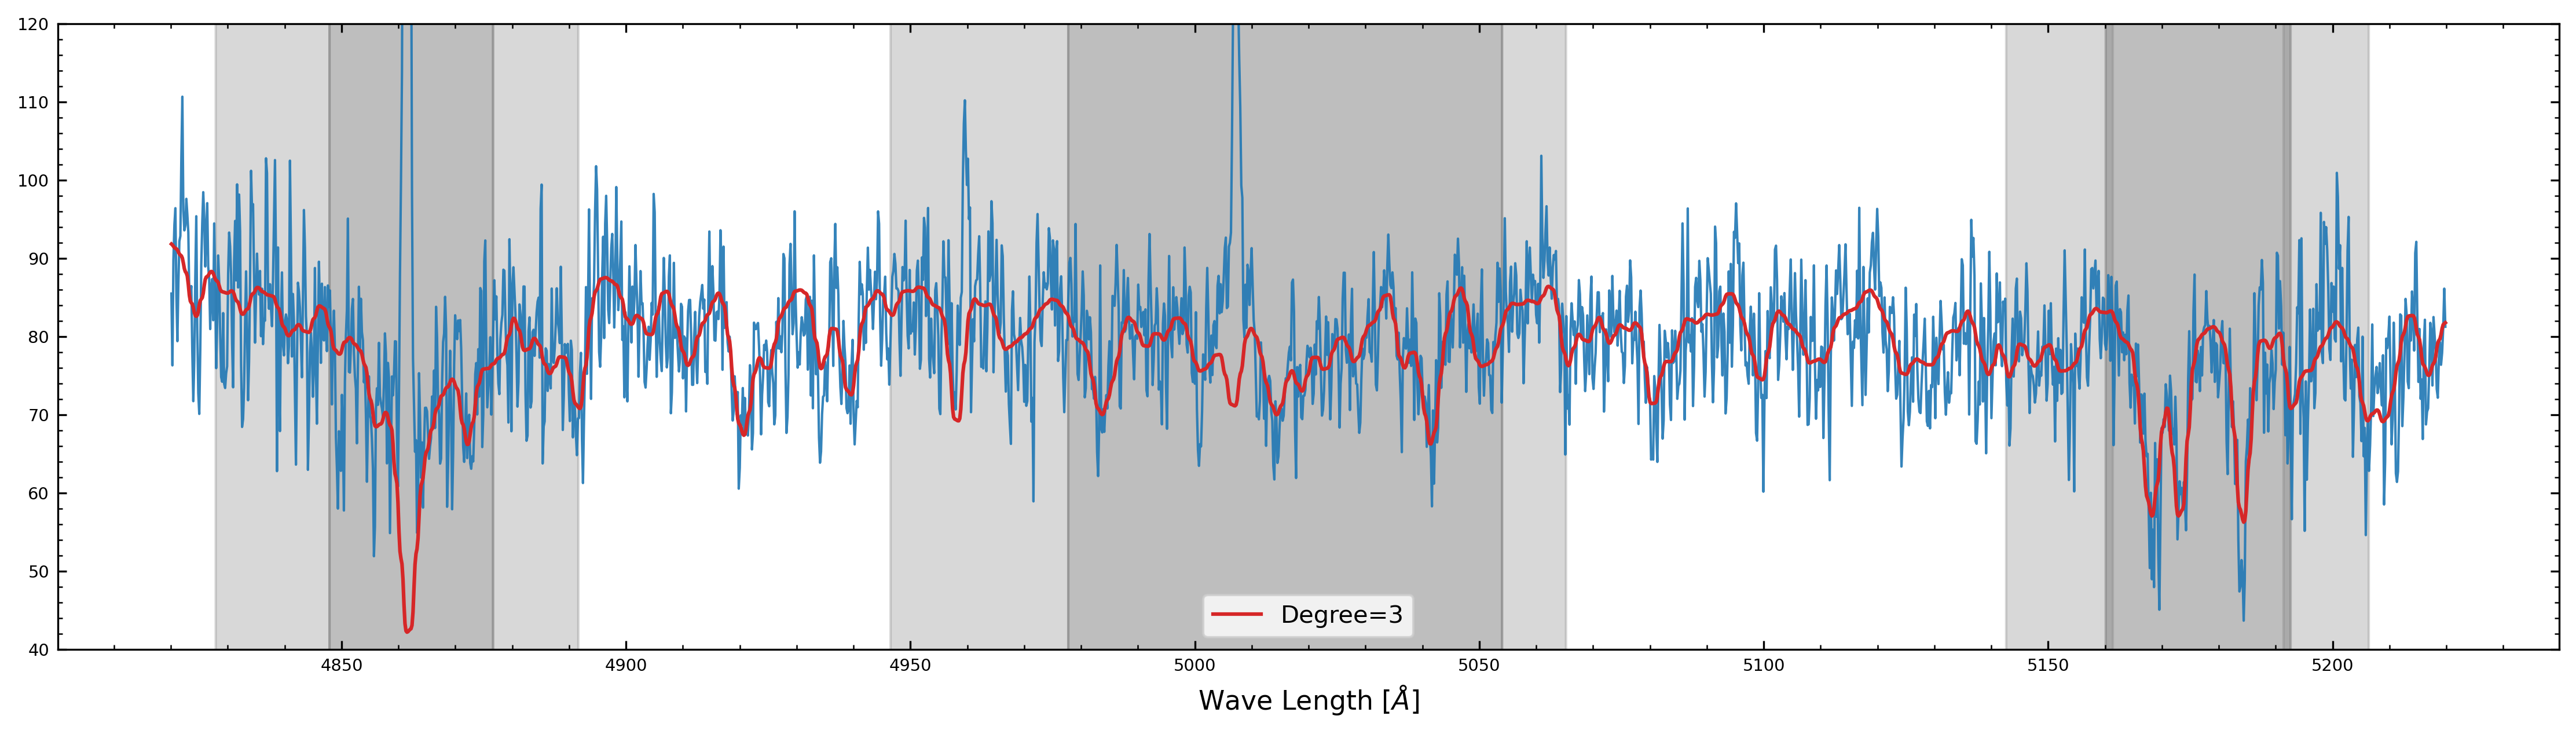

In [32]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,4), dpi=300, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.95, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

ax1.plot(lam_gal,Galaxy_info.spectra[:,1000], c='tab:blue', lw=1, alpha=.9)
ax1.plot(lam_gal,Bestfitfield[:,11,43], c='tab:red',label='Degree=3')

for i in Index_use:
    LHS = Index_Wave.loc[i,'CBP_range'][0]
    RHS = Index_Wave.loc[i,'CBP_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.5)

for i in Index_use:
    LHS = Index_Wave.loc[i,'BPC_range'][0]
    RHS = Index_Wave.loc[i,'BPC_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3)
for i in Index_use:
    LHS = Index_Wave.loc[i,'RPC_range'][0]
    RHS = Index_Wave.loc[i,'RPC_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3)


ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


ax1.set_xlabel(r'', size=11)
ax1.set_ylabel(r'', size=11)

ax1.set_ylim(40,120)
# ax1.set_xlim(0,1)
ax1.set_xlabel(r'Wave Length $[\AA]$', size=11)
ax1.legend()

# plt.savefig('./', format='pdf', bbox_inches='tight')

In [33]:
4851/(1+spectrum_z)

4830.711013742282

In [34]:
lam_range_gal = [np.min(lam_gal), np.max(lam_gal)]
gas_templates, gas_names, line_wave = util.emission_lines(sps.ln_lam_temp, lam_range_gal, Galaxy_info.fwhm_gal)

Emission lines included in gas templates:
['Hbeta' '[OIII]5007_d']


In [35]:
ngas_comp = 1   # I use three gas kinematic components
gas_templates = np.tile(gas_templates, ngas_comp)
gas_names = np.asarray([a + f"_({p+1})" for p in range(ngas_comp) for a in gas_names])
line_wave = np.tile(line_wave, ngas_comp)

In [36]:
galaxies = np.ndarray(shape= (Galaxy_info.spectra[:,0].shape[0],Galaxy_info.cube.shape[1],Galaxy_info.cube.shape[2]))

  0%|          | 0/23 [00:00<?, ?it/s]

differential_evolution step 1: f(x)= 104643
differential_evolution step 2: f(x)= 93638.9
differential_evolution step 3: f(x)= 93559.8


 52%|█████▏    | 12/23 [00:00<00:00, 45.90it/s]

differential_evolution step 4: f(x)= 93481.4
differential_evolution step 5: f(x)= 93481.4
differential_evolution step 6: f(x)= 93481.4
 Best Fit:       Vel     sigma
 comp.  0:        35        20
 comp.  1:        12        28
chi2/DOF: 42.54; DOF: 2197; degree = 0; mdegree = 0
Global search - Func calls: 210
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/3
Templates weights:
     0.912  1.62e+03       547
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      1616.       3.5      12    28
Comp:  1      [OIII]5007_d_(1)      727.4       4.4      12    28
-----------------------------------------------------------------


100%|██████████| 23/23 [00:00<00:00, 87.64it/s]


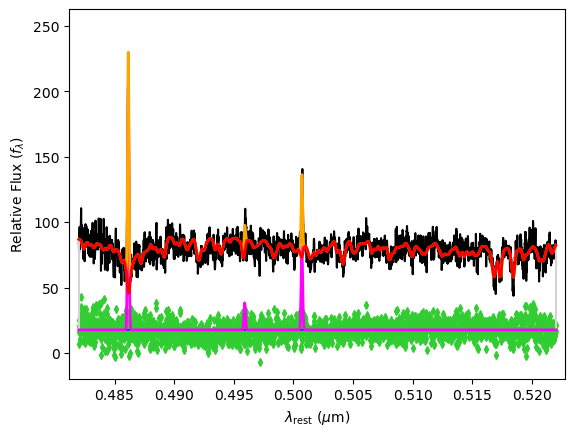

In [37]:
PP_box = []
for i in tqdm(range(galaxies.shape[1])):
    for j in range(galaxies.shape[2]):
        if(i == 11 and j == 43):                 # -------------------------- Here is the test sentence -------------------------- Here is the test sentence
            galaxy = Galaxy_info.spectra[:,i*max(Galaxy_info.col)+j]
            noise = np.ones_like(galaxy)

            template = optimal_templates[:,i,j]
            stars_gas_templates = np.column_stack([template, gas_templates])

            component = [0] + [1]*2
            gas_component=np.array(component) > 0
            moments = [-2, 2]
            ncomp = len(moments)
            tied = [['', ''] for _ in range(ncomp)]

            start = [[velfield[i,j], sigfield[i,j]],
            [velfield[i,j], 50]]

            vlim = lambda x: velfield[i,j] + x*np.array([-100, 100])
            bounds = [[vlim(2), [20, 300]],
                    [vlim(2), [20, 100]]]

            pp = ppxf(stars_gas_templates, galaxy, noise, Galaxy_info.velscale, start,
                plot=1, moments=moments, degree=0, mdegree=-1, component=component, 
                gas_component=gas_component, gas_names=gas_names,
                lam=lam_gal, lam_temp=sps.lam_temp, tied=tied,
                bounds=bounds,
                global_search=True)
            
            PP_box += [pp]

In [38]:
stars_gas_templates.shape

(93618, 3)

In [39]:
stars_gas_templates @ PP_box[0].weights

array([15.05746295, 15.05746295, 15.05746295, ...,  0.46472484,
        0.46472484,  0.46472484])

In [40]:
# plt.hist(PP_box[0].apoly)

In [41]:
PP_box[0].gas_bestfit_templates.shape

(2199, 2)

In [42]:
PP_box[0].matrix.shape

(2199, 4)

In [43]:
PP_box[0].apoly.shape

(2199,)

In [44]:
PP_box[0].galaxy.shape

(2199,)

In [45]:
Spectrum_AL = stars_gas_templates @ PP_box[0].weights

In [46]:
def make_bins(wavs):
    """ Given a series of wavelength points, find the edges and widths
    of corresponding wavelength bins. """
    edges = np.zeros(wavs.shape[0]+1)
    widths = np.zeros(wavs.shape[0])
    edges[0] = wavs[0] - (wavs[1] - wavs[0])/2
    widths[-1] = (wavs[-1] - wavs[-2])
    edges[-1] = wavs[-1] + (wavs[-1] - wavs[-2])/2
    edges[1:-1] = (wavs[1:] + wavs[:-1])/2
    widths[:-1] = edges[1:-1] - edges[:-2]

    return edges, widths

In [47]:
def spectres(new_wavs, spec_wavs, spec_fluxes, spec_errs=None, fill=None,
             verbose=True):

    """
    Function for resampling spectra (and optionally associated
    uncertainties) onto a new wavelength basis.

    Parameters
    ----------

    new_wavs : numpy.ndarray
        Array containing the new wavelength sampling desired for the
        spectrum or spectra.

    spec_wavs : numpy.ndarray
        1D array containing the current wavelength sampling of the
        spectrum or spectra.

    spec_fluxes : numpy.ndarray
        Array containing spectral fluxes at the wavelengths specified in
        spec_wavs, last dimension must correspond to the shape of
        spec_wavs. Extra dimensions before this may be used to include
        multiple spectra.

    spec_errs : numpy.ndarray (optional)
        Array of the same shape as spec_fluxes containing uncertainties
        associated with each spectral flux value.

    fill : float (optional)
        Where new_wavs extends outside the wavelength range in spec_wavs
        this value will be used as a filler in new_fluxes and new_errs.

    verbose : bool (optional)
        Setting verbose to False will suppress the default warning about
        new_wavs extending outside spec_wavs and "fill" being used.

    Returns
    -------

    new_fluxes : numpy.ndarray
        Array of resampled flux values, first dimension is the same
        length as new_wavs, other dimensions are the same as
        spec_fluxes.

    new_errs : numpy.ndarray
        Array of uncertainties associated with fluxes in new_fluxes.
        Only returned if spec_errs was specified.
    """

    # Rename the input variables for clarity within the function.
    old_wavs = spec_wavs
    old_fluxes = spec_fluxes
    old_errs = spec_errs

    # Make arrays of edge positions and widths for the old and new bins

    old_edges, old_widths = make_bins(old_wavs)
    new_edges, new_widths = make_bins(new_wavs)

    # Generate output arrays to be populated
    new_fluxes = np.zeros(old_fluxes[..., 0].shape + new_wavs.shape)

    if old_errs is not None:
        if old_errs.shape != old_fluxes.shape:
            raise ValueError("If specified, spec_errs must be the same shape "
                             "as spec_fluxes.")
        else:
            new_errs = np.copy(new_fluxes)

    start = 0
    stop = 0

    # Calculate new flux and uncertainty values, looping over new bins
    for j in range(new_wavs.shape[0]):

        # Add filler values if new_wavs extends outside of spec_wavs
        if (new_edges[j] < old_edges[0]) or (new_edges[j+1] > old_edges[-1]):
            new_fluxes[..., j] = fill

            if spec_errs is not None:
                new_errs[..., j] = fill

            # if (j == 0 or j == new_wavs.shape[0]-1) and verbose:
            #     warnings.warn(
            #         "Spectres: new_wavs contains values outside the range "
            #         "in spec_wavs, new_fluxes and new_errs will be filled "
            #         "with the value set in the 'fill' keyword argument "
            #         "(by default 0).",
            #         category=RuntimeWarning,
            #     )
            continue

        # Find first old bin which is partially covered by the new bin
        while old_edges[start+1] <= new_edges[j]:
            start += 1

        # Find last old bin which is partially covered by the new bin
        while old_edges[stop+1] < new_edges[j+1]:
            stop += 1

        # If new bin is fully inside an old bin start and stop are equal
        if stop == start:
            new_fluxes[..., j] = old_fluxes[..., start]
            if old_errs is not None:
                new_errs[..., j] = old_errs[..., start]

        # Otherwise multiply the first and last old bin widths by P_ij
        else:
            start_factor = ((old_edges[start+1] - new_edges[j])
                            / (old_edges[start+1] - old_edges[start]))

            end_factor = ((new_edges[j+1] - old_edges[stop])
                          / (old_edges[stop+1] - old_edges[stop]))

            old_widths[start] *= start_factor
            old_widths[stop] *= end_factor

            # Populate new_fluxes spectrum and uncertainty arrays
            f_widths = old_widths[start:stop+1]*old_fluxes[..., start:stop+1]
            new_fluxes[..., j] = np.sum(f_widths, axis=-1)
            new_fluxes[..., j] /= np.sum(old_widths[start:stop+1])

            if old_errs is not None:
                e_wid = old_widths[start:stop+1]*old_errs[..., start:stop+1]

                new_errs[..., j] = np.sqrt(np.sum(e_wid**2, axis=-1))
                new_errs[..., j] /= np.sum(old_widths[start:stop+1])

            # Put back the old bin widths to their initial values
            old_widths[start] /= start_factor
            old_widths[stop] /= end_factor

    # If errors were supplied return both new_fluxes and new_errs.
    if old_errs is not None:
        return new_fluxes, new_errs

    # Otherwise just return the new_fluxes spectrum array
    else:
        return new_fluxes

In [48]:
def Spectrum_ReSMP_2(spctrum, lam_gal_wave, new_wave, v_fix):
    Lam_gal_cpy_U = lam_gal_wave.copy()
    for i in range(len(Lam_gal_cpy_U)):
        Lam_gal_cpy_U[i] = Lam_gal_cpy_U[i]/(1+(v_fix/c))
    # lam_gal = np.array(lam_gal_wave)
    # W_arg = np.arange(st, ed, (ed-st)/(len(Lam_gal_cpy_U)))
    # W_list = []
    # for i in range(len(lam_gal)):
    #     W_list += [st+i*(ed-st)/(len(lam_gal_wave)-1)]
    return spectres(new_wave, Lam_gal_cpy_U, spctrum)

In [49]:
PP_box[0].gas_reddening

In [50]:
stars_gas_templates.shape

(93618, 3)

In [51]:
stars_gas_templates[:,0] * PP_box[0].weights[0] + np.poly1d(apoly_se)(sps.lam_temp)

array([ 4.09245383e+04,  4.09223081e+04,  4.09200778e+04, ...,
       -9.84829464e+07, -9.84948565e+07, -9.85067681e+07])

In [52]:
(stars_gas_templates @ PP_box[0].weights).shape

(93618,)

In [53]:
apoly_se_2 = np.polyfit(lam_gal, PP_box[0].apoly, 3)


C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_16616\3001183339.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


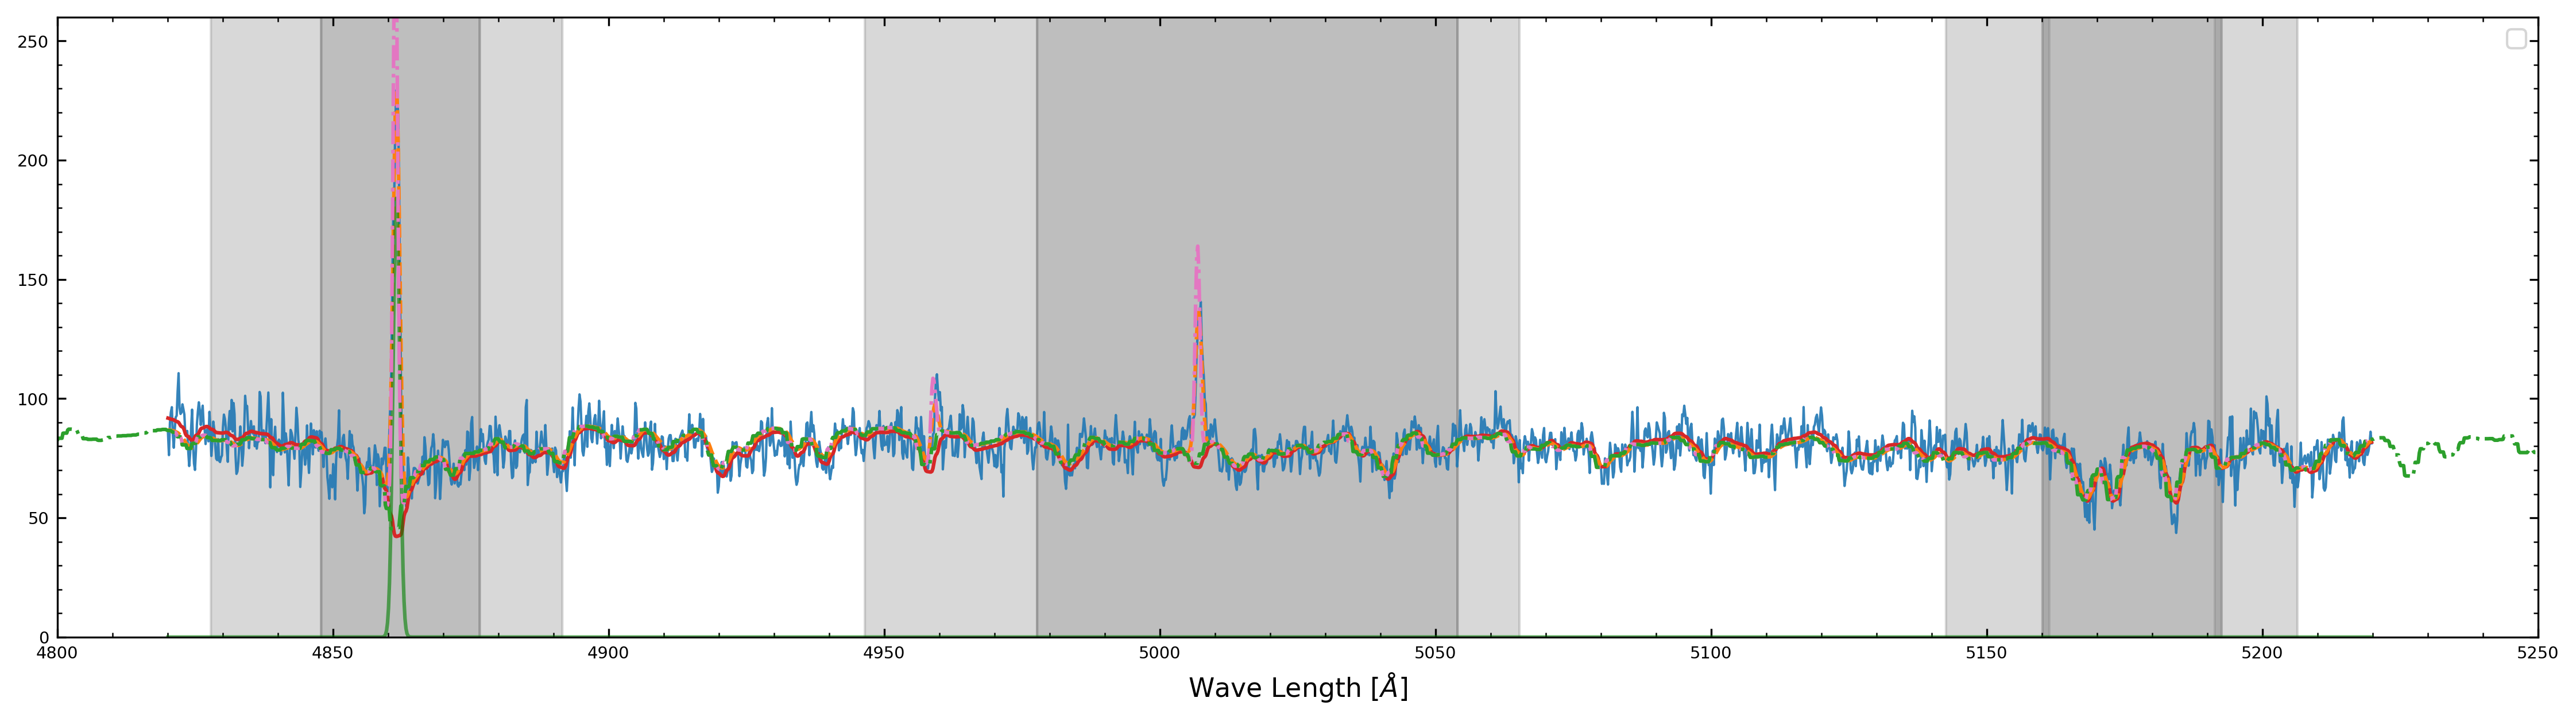

In [54]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,4), dpi=300, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.95, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

ax1.plot(lam_gal,Galaxy_info.spectra[:,1000], c='tab:blue', lw=1, alpha=.9)
ax1.plot(lam_gal,Bestfitfield[:,11,43], c='tab:red')

for i in Index_use:
    LHS = Index_Wave.loc[i,'CBP_range'][0]
    RHS = Index_Wave.loc[i,'CBP_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.5)

for i in Index_use:
    LHS = Index_Wave.loc[i,'BPC_range'][0]
    RHS = Index_Wave.loc[i,'BPC_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3)
for i in Index_use:
    LHS = Index_Wave.loc[i,'RPC_range'][0]
    RHS = Index_Wave.loc[i,'RPC_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3)


ax1.plot(lam_gal,PP_box[0].bestfit,'--',color='tab:orange')

ax1.plot(lam_gal,PP_box[0].gas_bestfit_templates[:,0],color='green',alpha=.6)
ax1.plot(lam_gal, Spectrum_ReSMP_2(stars_gas_templates @ PP_box[0].weights, sps.lam_temp, lam_gal, 0)+PP_box[0].apoly, '-.',ms=.5, color='tab:pink')
ax1.plot(sps.lam_temp, stars_gas_templates[:,0] * PP_box[0].weights[0] + np.poly1d(apoly_se_2)(sps.lam_temp), '-.',ms=.5, color='tab:green')



ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


ax1.set_xlabel(r'', size=11)
ax1.set_ylabel(r'', size=11)

ax1.set_ylim(0,260)
ax1.set_xlim(4800,5250)
ax1.set_xlabel(r'Wave Length $[\AA]$', size=11)
ax1.legend()

# plt.savefig('./', format='pdf', bbox_inches='tight')

In [55]:
sps.lam_temp.shape

(93618,)

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_16616\2806765298.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


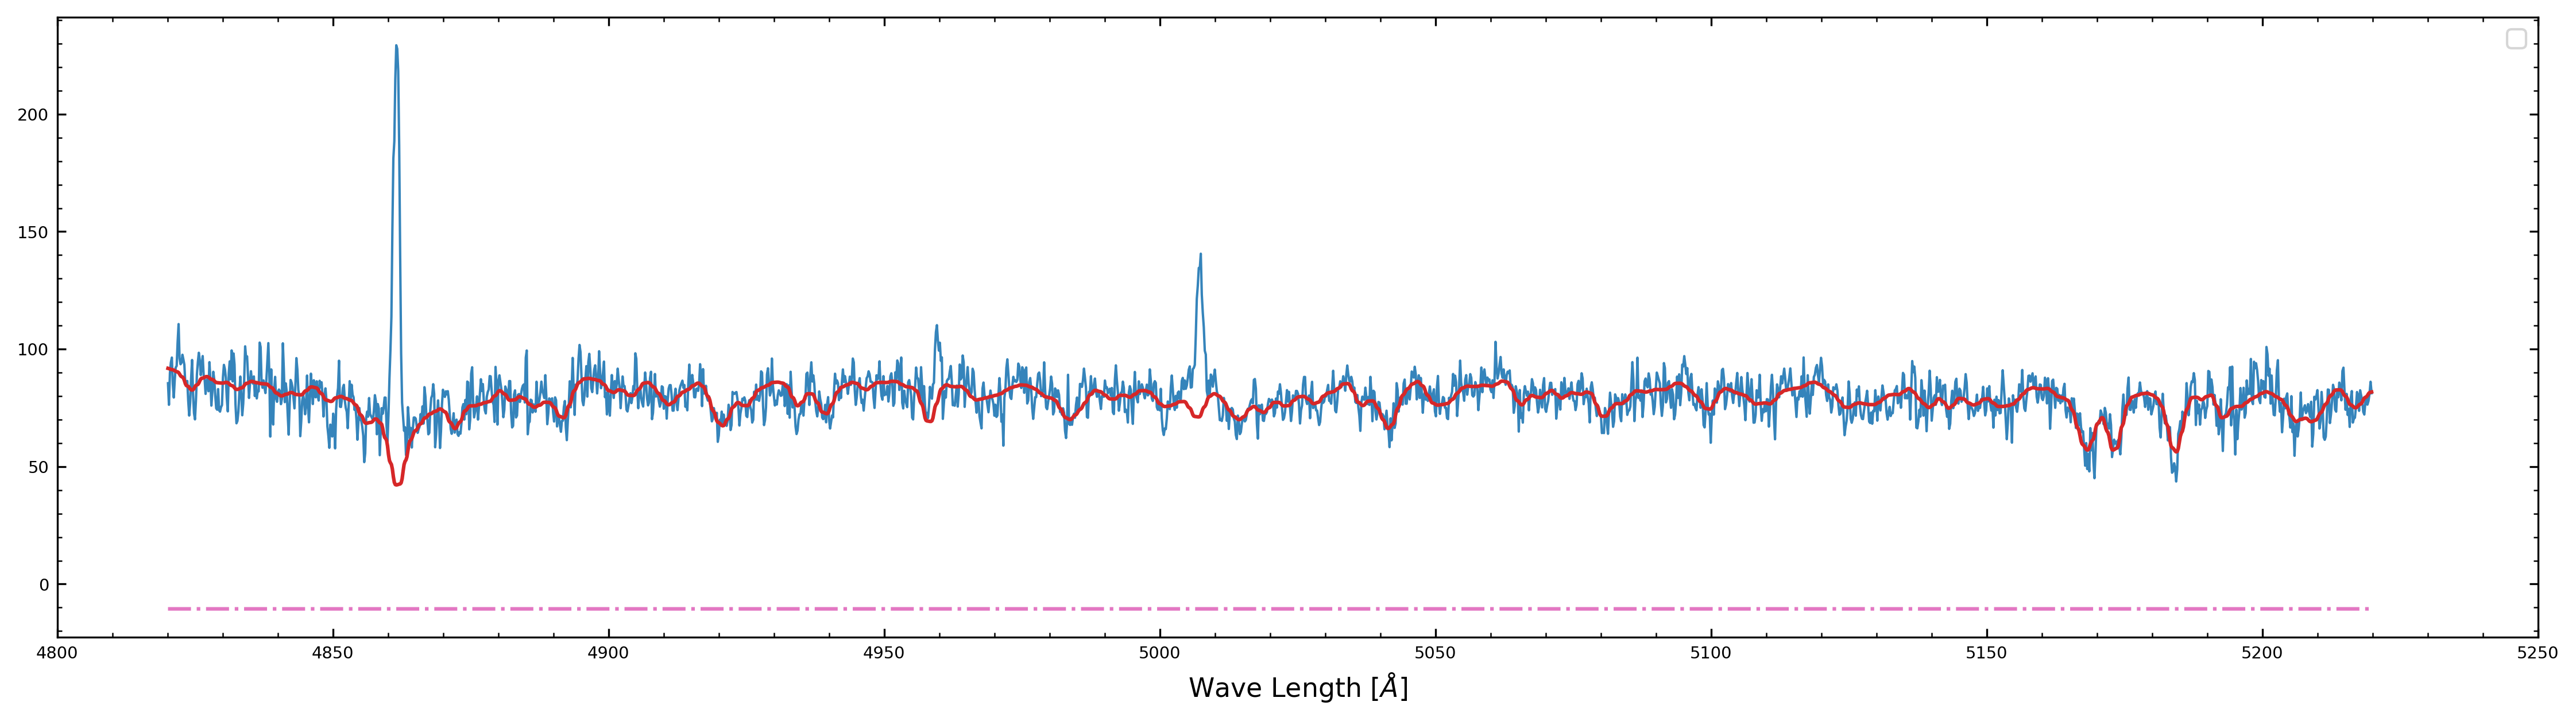

In [56]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,4), dpi=300, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.95, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

ax1.plot(lam_gal,Galaxy_info.spectra[:,1000], c='tab:blue', lw=1, alpha=.9)
ax1.plot(lam_gal,Bestfitfield[:,11,43], c='tab:red')

# for i in Index_use:
#     LHS = Index_Wave.loc[i,'CBP_range'][0]
#     RHS = Index_Wave.loc[i,'CBP_range'][1]
#     ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.5)

# for i in Index_use:
#     LHS = Index_Wave.loc[i,'BPC_range'][0]
#     RHS = Index_Wave.loc[i,'BPC_range'][1]
#     ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3)
# for i in Index_use:
#     LHS = Index_Wave.loc[i,'RPC_range'][0]
#     RHS = Index_Wave.loc[i,'RPC_range'][1]
#     ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3)


# ax1.plot(lam_gal,PP_box[0].bestfit,'--',color='tab:orange')

# ax1.plot(sps.lam_temp,stars_gas_templates @ PP_box[0].weights,color='green',alpha=.6)
ax1.plot(lam_gal, PP_box[0].apoly, '-.',ms=.5, color='tab:pink')



ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


ax1.set_xlabel(r'', size=11)
ax1.set_ylabel(r'', size=11)

# ax1.set_ylim(0,260)
ax1.set_xlim(4800,5250)
ax1.set_xlabel(r'Wave Length $[\AA]$', size=11)
ax1.legend()

# plt.savefig('./', format='pdf', bbox_inches='tight')